In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from ssri_interactions.config import Config, ExperimentInfo
from ssri_interactions.plots.heatmaps import similarity_map
from ssri_interactions.plots.umap import plot_umap
from ssri_interactions.io import load_derived_generic

from ssri_interactions.decoding.loaders import FSFastDecodeDataLoaderTwoWindows
from ssri_interactions.decoding.preprocessors import DecodePreprocessor
from ssri_interactions.transforms.spikes import SpikesHandler
from ssri_interactions.io import load_events
from ssri_interactions.transforms.shock_transforms import ShockUtils

c:\ProgramData\Miniconda3\envs\ssri\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
sns.set_theme(context="paper", style="ticks")

In [7]:
# sns.set_theme(context="paper", style="ticks", font_scale=1.5)

In [8]:
# load PSTH and F1 Scores

neuron_types = load_derived_generic("neuron_types.csv")
df_counts = pd.read_parquet(Config.derived_data_dir / "baseshock_counts_psth.parquet")
df_psth_sal = (
    df_counts.query("group == 'SAL'")
    .pivot(index="bin", columns="neuron_id", values="counts")
)
df_psth_cit = (
    df_counts.query("group == 'CIT'")
    .pivot_table(index="bin", columns="neuron_id", values="zcounts")
)

df_f1_pop = load_derived_generic(
    "decoding/fs_fast - pop - windows.csv"
)
df_f1_su = load_derived_generic(
    "decoding/fs_fast - unit - windows.csv"
)


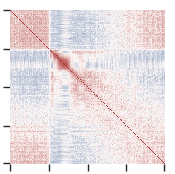

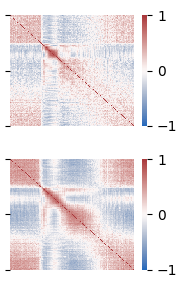

In [9]:
def plot_similarity_map(df, **figure_kwargs):
    f = plt.figure(**figure_kwargs)
    ax = f.subplots()
    similarity_map(
        df_binned_piv=df,
        z=True, 
        metric="cosine",
        ax=ax,
        heatmap_kwargs=dict(cmap="vlag", vmin=-1, vmax=1, robust=True, cbar=False),
        )
    ax.set_yticks([0, 50, 100, 150, 199])
    ax.set_xticks([0, 50, 100, 150, 199])
    return f, ax


f_sal, ax_sal = plot_similarity_map(df_psth_sal.dropna(axis=1), figsize=(2, 2))
f_cit, ax_cit = plot_similarity_map(df_psth_sal.dropna(axis=1), figsize=(2, 2))

f_sal.savefig(fig_dir / "fs_fast_sal_similarity_map.png", bbox_inches="tight", dpi=300)
f_cit.savefig(fig_dir / "fs_fast_cit_similarity_map.png", bbox_inches="tight", dpi=300)

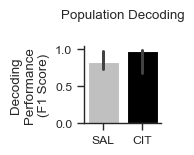

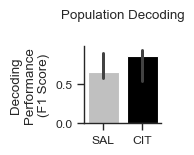

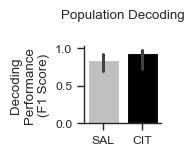

In [9]:
from ssri_interactions.plots.pallets_cmaps import PAL_GREY_BLACK


def plot_pop(df, window, **figure_kwargs):
    f = plt.figure(**figure_kwargs)
    ax = f.subplots()
    sns.barplot(
        data=df.query(f"window == '{window}'"),
        x="group",
        y="pop_true",
        ax=ax,
        palette=PAL_GREY_BLACK[::-1],
        estimator=np.median
    )
    ax.set_ylabel("Decoding\nPerformance\n(F1 Score)")
    ax.set_xlabel("")
    ax.set_title("Population Decoding", pad=20)
    sns.despine(fig=f, offset=0)
    return f, ax


f_w1, ax_w1 = plot_pop(df_f1_pop, "w1", figsize=(1, 1))
f_w2, ax_w2 = plot_pop(df_f1_pop, "w2", figsize=(1, 1))
f_comp, ax_comp = plot_pop(df_f1_pop, "comp", figsize=(1, 1))

f_w1.savefig(fig_dir / "fs_fast_w1_pop.png", bbox_inches="tight", dpi=300)
f_w2.savefig(fig_dir / "fs_fast_w2_pop.png", bbox_inches="tight", dpi=300)
f_comp.savefig(fig_dir / "fs_fast_comp_pop.png", bbox_inches="tight", dpi=300)

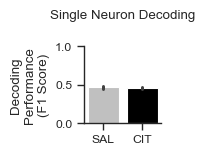

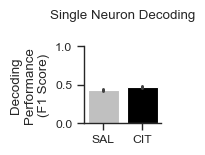

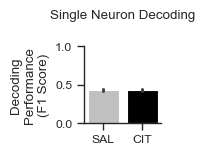

In [10]:
def plot_unit(df, window, **figure_kwargs):
    f = plt.figure(**figure_kwargs)
    ax_neuron = f.subplots()
    sns.barplot(
        data=df.query(f"window == '{window}'"),
        x="group",
        y="F1 Score",
        ax=ax_neuron,
        palette=PAL_GREY_BLACK[::-1],
        estimator=np.mean
    )

    ax_neuron.set_ylabel("Decoding\nPerformance\n(F1 Score)")
    ax_neuron.set_xlabel("")
    ax_neuron.set_ylim(0, 1)
    ax_neuron.set_title("Single Neuron Decoding", pad=20)
    sns.despine(fig=f)
    return f, ax_neuron 


f_w1, ax_w1 = plot_unit(df_f1_unit, "w1", figsize=(1, 1))
f_w2, ax_w2 = plot_unit(df_f1_unit, "w2", figsize=(1, 1))
f_comp, ax_comp = plot_unit(df_f1_unit, "comp", figsize=(1, 1))

f_w1.savefig(fig_dir / "fs_fast_w1_unit.png", bbox_inches="tight", dpi=300)
f_w2.savefig(fig_dir / "fs_fast_w2_unit.png", bbox_inches="tight", dpi=300)
f_comp.savefig(fig_dir / "fs_fast_comp_unit.png", bbox_inches="tight", dpi=300)

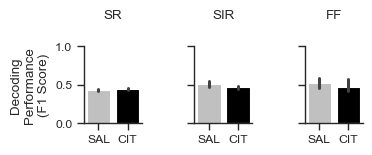

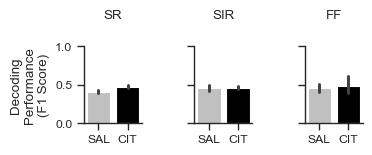

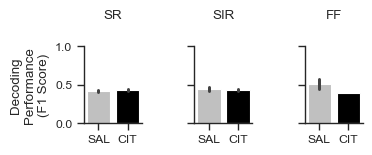

In [11]:
import warnings

def plot_neuron_facet(df, window, ):
    g = sns.FacetGrid(
        data=df.query(f"window == '{window}'"),
        col="neuron_type",
        col_order=["SR", "SIR", "FF"],
        height=1,
        aspect=1.2,
        gridspec_kws=dict(wspace=0.9),
    )
    g.map_dataframe(
        sns.barplot, 
        x="group", 
        y="F1 Score", 
        palette=PAL_GREY_BLACK[::-1],
        # estimator=np.median
    )

    # ax_neuron = g
    g.set_ylabels("Decoding\nPerformance\n(F1 Score)")
    g.set_xlabels("")
    g.set_titles("{col_name}", pad = 20)

    for ax in g.axes.flatten():
        ax.set_ylim(0, 1)
    return g

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    g_w1 = plot_neuron_facet(df_f1_unit, "w1",)
    g_w2 = plot_neuron_facet(df_f1_unit, "w2", )
    g_comp = plot_neuron_facet(df_f1_unit, "comp", )

g_w1.savefig(fig_dir / "fs_fast_w1_neuron_facet.png", bbox_inches="tight", dpi=300)
g_w2.savefig(fig_dir / "fs_fast_w2_neuron_facet.png", bbox_inches="tight", dpi=300)
g_comp.savefig(fig_dir / "fs_fast_comp_neuron_facet.png", bbox_inches="tight", dpi=300)

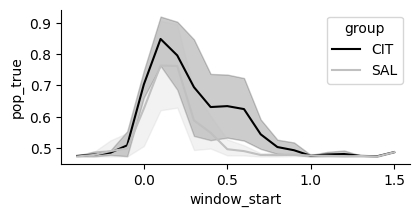

In [19]:
from ssri_interactions.plots.pallets_cmaps import PAL_GREY_BLACK

neuron_types = load_derived_generic("neuron_types.csv")

f_offset = plt.figure(figsize=(4.5, 2))
ax_offset = f_offset.subplots()


(
    df_f1_pop
    .merge(neuron_types[["session_name", "group"]].drop_duplicates(), on="session_name")
    .pipe(lambda x: sns.lineplot(
        data=x,
        x="window_start",
        y="pop_true",
        hue="group",
        ax=ax_offset,
        palette=PAL_GREY_BLACK,
        hue_order=["CIT", "SAL"],
    ))
)
sns.despine(fig=f_offset)

In [ ]:
df_f1_pop
    .merge(neuron_types[["session_name", "group"]].drop_duplicates(), on="session_name")
    .pipe(lambda x: sns.lineplot(
        data=x,
        x="window_start",
        y="pop_true",
        hue="group",
        ax=ax_offset,
        palette=PAL_GREY_BLACK,
        hue_order=["CIT", "SAL"],
    ))
)